<div class="alert alert-block alert-info">
<b> </b> </div>

<h1 style="text-align: center">Segmenting an online retail company's customers</h1>

<div class="alert alert-block alert-info">
<b> </b> </div>

<h1 style="text-align: center"> Part II: Online retail market segmentation sales transactions</h1>

<div class="alert alert-block alert-info">
<b> </b> </div>

# Collect the Data

## Importing the Python Packages

import the required Python packages.

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from matplotlib import pyplot as plt
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set_theme()
sns.set(font_scale=2)
sns.set(rc={"figure.figsize":(12, 8)}) #width=6, height=5
from scipy.stats import pearsonr # import pearsonr function to calculate  Pearson correlation coefficient

Import the data into a dataframe called `dfs`.

In [2]:
dfs = pd.read_excel("C:/Users/ke337467/OneDrive - Oxfordshire County Council/Data Scientist Apprenticeship/Module Portfolio - Data Science Professional Practice/Retail_Market/Sales_Data.xlsx")

Drop the original index colummn as it is duplicated on import. 

In [3]:
dfs = dfs.drop(['Unnamed: 0'], axis=1)
dfs.head()

,CustomerID,Amount,Frequency,Recency,Amount_S,Frequency_S,Recency_S
0,12347,4310.00,7,3,0.151741,0.066905,-0.178622
1,12348,1797.24,4,76,0.135074,-0.667737,-0.748685
2,12349,1757.55,1,19,-0.462564,-0.667737,2.171637
3,12350,334.40,1,311,0.449395,1.046429,-0.568665
4,12352,2506.04,8,37,-0.565617,-0.667737,1.111520


Drop the CustomerID as it will influence the statistial measures. See warning below

<div class="alert alert-block alert-danger">
<b>Warning:</b> It is important to remove the `CustomerID` as this is a numerical field and can negatively influence the statistical measures used to calculate the number of clusters.
</div>

In [4]:
dfss = dfs.drop(['Amount','Frequency','Recency','CustomerID'], axis=1)
dfss.head()

,Amount_S,Frequency_S,Recency_S
0,0.151741,0.066905,-0.178622
1,0.135074,-0.667737,-0.748685
2,-0.462564,-0.667737,2.171637
3,0.449395,1.046429,-0.568665
4,-0.565617,-0.667737,1.111520


## Viual exploration of the dataset 

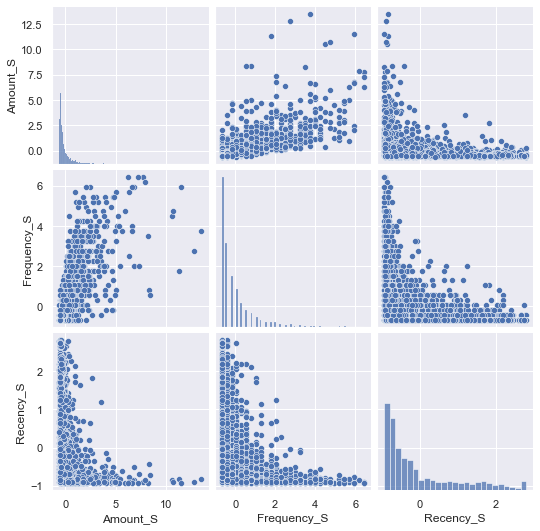

In [5]:
sns.pairplot(dfss[['Amount_S','Frequency_S','Recency_S']])

<div class="alert alert-block alert-info">
<b> </b> </div>

<h1 style="text-align: center">Cluster Analysis of online retail sales</h1>

<div class="alert alert-block alert-info">
<b> </b> </div>

## The standardised values in Amount, Frequency and Recency.

In [6]:
dfss.describe().round(2)

,Amount_S,Frequency_S,Recency_S
count,4233.00,4233.00,4233.00
mean,-0.00,0.00,-0.00
std,0.99,1.00,1.00
min,-0.60,-0.67,-0.93
25%,-0.47,-0.67,-0.75
50%,-0.33,-0.42,-0.42
75%,0.07,0.07,0.50
max,13.53,6.43,2.80


Reviewing the data frame above note that `Amount`, `Frequency` and `Recency` have a standard deviation of one and a mean of zero. (The approach is Z-score normalization).

<div class="alert alert-block alert-info">
<b> </b> </div>

<h1 style="text-align: center">Statistically choosing the right number of clusters</h1>


<div class="alert alert-block alert-info">
<b> </b> </div>

## Using statistical measures to calculate the appropriate number of clusters

>* Within Cluster Sum of Squares (WCSS)  
>* Average Silhouette Score  
>* Calinski Harabasz Score  


### The Within Cluster Sum of Squares (WCSS)
This approach is also known as the `Elbow method`  

Approach used:
>* Create and empty list `wcss`
>* Iterate values for k from 2 to 10. (*Note:* stop value in the range function, 11 is exclusive)
>* For each `k`, cluster the data (as done in `Section 6.1` and `6.1.1.` but note that the value for the number of clusters is `k`).
>* The second last step in the iteration `(kmeans.inertia_)` calculates the `wcss value` for each iteration
>* The last step in the iteration appends the `wcss value` to the `wcss` list.

**Note:** after irritating all nine k values, the `wcss` list will contain the `wcss value` for each `k` in the list.

* When the loop is completed convert the wcss list into a Pandas Series

Create a line plot with
* y-axis = wcss
* x-axis = k values

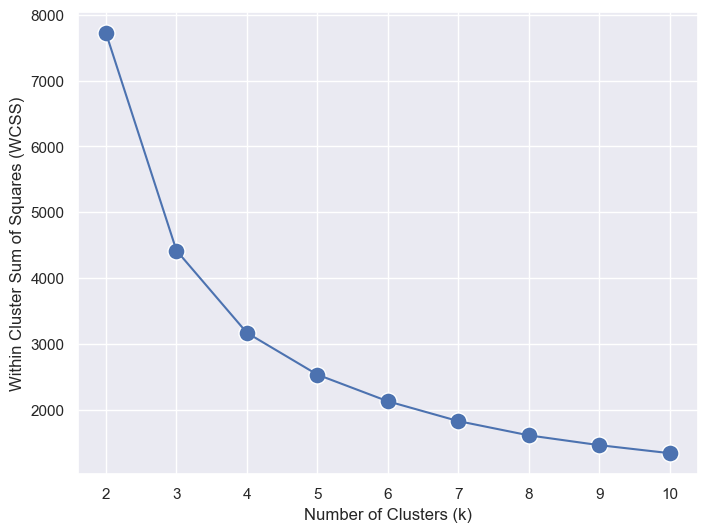

In [7]:
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, n_init = 25, random_state = 1234)
    kmeans.fit(dfss)
    wcss.append(kmeans.inertia_)

wcss_series = pd.Series(wcss, index = range(2, 11))

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = wcss_series, x = wcss_series.index)
ax = sns.scatterplot(y = wcss_series, x = wcss_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Within Cluster Sum of Squares (WCSS)')

#### Observation

Examining the plot the elbow is not quite clearly defined. The elbow starts at `k = 3` but `k = 4` could also be relevant as it is at these points that increasing the value of `k` no longer reduces WCSS significantly.  

<div class="alert alert-block alert-warning">
<b>Note:</b> It is difficult to discern the elbow as the line display is more of an even curve than the more distinct WCSS elbow. Addition methods will be used to discern the current number off clusters.
</div>

### The Average Silhouette Score


Approach used:  
>* Create and empty list `silhouette`
>* Iterate values for k from 2 to 10. (Note: stop value in the range function, 11 is exclusive)
>* For each k, cluster the data (as done in Section 5.1 and 5.1.1. but note that the value for the number of clusters is `k`)
>* The second last step in the iteration `( silhouette_score)` calculates the average `silhouette_score` for each k during each iteration
>* The last step in the iteration appends the `silhouette_score`.

**Note:** after irritating all nine k values, the `silhouette` list will contain the `silhouette_score` for each k in the list.

* When the loop is completed convert the `silhouette` list into a Pandas Series

Create a line plot with:
* y-axis = silhouette score
* x-axis = k values

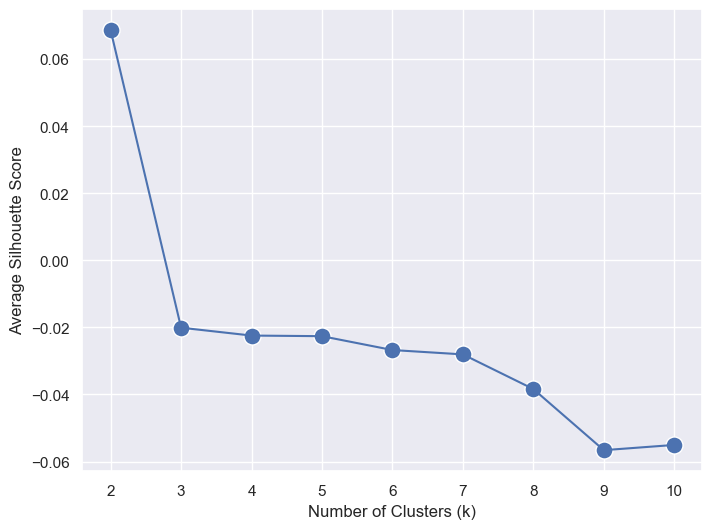

In [8]:
silhouette = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, n_init = 25, random_state = 1234)
    kmeans.fit(dfss)
    silhouette.append(silhouette_score(dfs, kmeans.labels_))

silhouette_series = pd.Series(silhouette, index = range(2, 11))

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = silhouette_series, x = silhouette_series.index)
ax = sns.scatterplot(y = silhouette_series, x = silhouette_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Average Silhouette Score')

#### Observations

With the average silhouette method, the k value corresponding to the highest average silhouette score represents the optimal number of clusters. 

<div class="alert alert-block alert-warning">
<b>Note:</b> Examining the chart reveals that the values peak  when `k = 2`. This k value is not the same as the `WCSS k value` which showed the elbow (though not easy to discern) as being either 3 or 4.
</div>

### The Calinski Harabasz Score

Approach used:  
>* Create and empty list `chs`
>* Iterate values for k from 2 to 10. (Note: stop value in the range function, 11 is exclusive)
>* For each k, cluster the data (as done in Section 6.1 and 6.1.1. but note that the value for the number of clusters is `k`)
>* The second last step in the iteration `( calinski_harabasz_score)` calculates the `calinski_harabasz_score` for each k during each iteration
>* The last step in the iteration appends the `calinski_harabasz_score` to the list `chs`

**Note:** after irritating all nine k values, the `chs` list will contain the `calinski_harabasz_score` for each k in the list.

* When the loop is completed convert the `chs` list into a Pandas Series

Create a line plot with
* y-axis = Calinski Harabasz Score
* x-axis =  k values

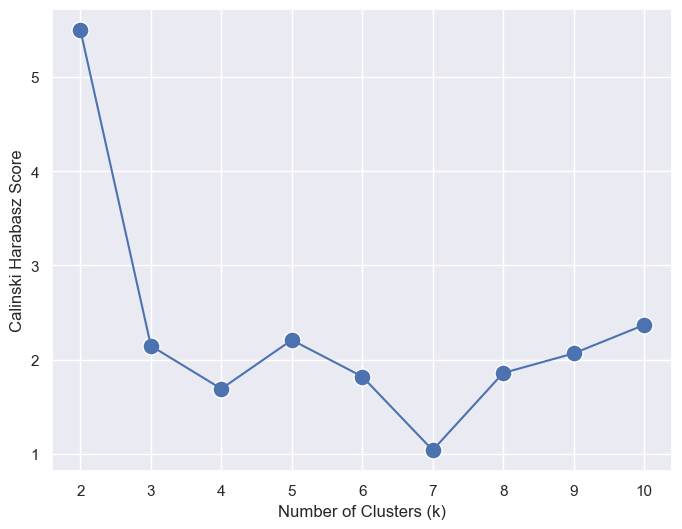

In [9]:
chs = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, n_init = 25, random_state = 1234)
    kmeans.fit(dfss)
    chs.append(calinski_harabasz_score(dfs, kmeans.labels_))

calinski_series = pd.Series(chs, index = range(2, 11))

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = calinski_series, x = calinski_series.index)
ax = sns.scatterplot(y = calinski_series, x = calinski_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Calinski Harabasz Score')

#### Observations

Using the Calinski-Harabasz score, the optimal value for k is that which corresponds to either the highest score or the first abrupt elbow in the chart. 

* The first abrupt elbow is when `k = 3`
* The highest score is when `k = 2`.

## Conclusion: Optimal number of clusters
Results of the three tests
>* Within Cluster Sum of Squares (WCSS): `k = 3 or 4`.
>* Silhouette Score: `k = 2` the next highest being `k = 3`.
>* Calinski-Harabasz score: `k = 2 or 3`.

Considering that the `Silhouette` returned `k = 2` makes the process of clustering almost redundant. The alternative option is to use the `WCSS` and `Calinski-Harabasz` scores where `k = 3` or possibly `k = 4`. 

The `optimal k value` though not consistent across all three tests is `k = 3` or possibly `k = 4` . Please refer to Annex 1 where three clusters were used (`k = 3`). using 3 clusters was purely a learning exercise to determine what the clustering would be with 5 clusters **BUT** as expected this was found to be less favourable than using 4 clusters.

<div class="alert alert-block alert-info">
<b> </b> </div>

<h1 style="text-align: center">Create the Clusters using k = 4</h1>

<div class="alert alert-block alert-info">
<b> </b> </div>

To cluster the data using k-means clustering use the k-means class from the sklearn.cluster subpackage.

## Setting up the k-means clustering algorithm

Create a new object called `kmeans` from the k-means class.  
k-means requires three arguments:  
>1). ` n_clusters` argument determines the number of clusters. The estimated correct number of clusters based on the three tests above (`WCSS`, `Silhouette` and `Calinski-Harabasz`) is initially set `k = 5`, but changed to `k = 4` (please see `8.3. Evaluation of the centroid scatterplot (with k = 5)`for more details as why 4 cnetroids were chosed rather than 5.   
>2). ` n_init` this argument sets the number of times the k-means algorithm should be run with different central seeds. The default is 10. Set it to 25 (just to be sure).   
>3). `random_state` this argument sets the random initialisation seed which will be used to generate the cluster centres to 1, 2, 3, 4. Using this argument enables the reproduction of the results.  

In [10]:
kmeans = KMeans(n_clusters = 4, n_init = 25, random_state = 1234)

#### Use the fit method
Use the fit method of the kmeans object to cluster the data. 

In [11]:
kmeans.fit(dfss)

KMeans(n_clusters=4, n_init=25, random_state=1234)

#### Assign reference labels
*  get `cluster assignments` reference the labels attributes of the km object.  
* Cluster assignments correspond to the order of instances in the customer scale data set.  
* Output is a NumPy array of cluster assignments. 

In [12]:
kmeans.labels_

array([2, 2, 1, ..., 2, 0, 2])

#### Notes about labels
Cluster assignments correspond to the order of instances in the customer scale data frame. 
For example:
>* first item in the output array (also the first item in the dataset) is assigned to cluster 2
>* second last item is assigned to cluster 2
>* the last item in the array is in cluster 1.

### Using the inertia_ attribute in the k-means sub package
The output of this code is the total `WCSS (within-cluster sum of squares)` for the clusters.

In [13]:
kmeans.inertia_

3167.7698640434373

## Evaluate and Visualise the Clusters 
Count the number of items in each cluster

In [14]:
pd.Series(kmeans.labels_).value_counts().sort_index()

0     688
1    1008
2    2409
3     128
dtype: int64

### Comparing cluster size
Cluster 3 is disproportionately smaller than the other two clusters and will need further attention bring more balance to the clusters.  
It is possible that the initial number of clusters is not appropriate for this data set.
The centre of each cluster will provide useful information about the quality of the clusters.

### Return the coordinates of the centroids
The cluster_centers attribute returns the coordinates of the centroids (cluster centres) as a NumPy array.

In [15]:
kmeans.cluster_centers_

array([[ 0.77752535,  1.21549615, -0.67053693],
       [-0.42160288, -0.5514981 ,  1.58696506],
       [-0.26394271, -0.30458219, -0.43064998],
       [ 4.03498983,  3.60428602, -0.81330161]])

#### Create a data frame for the cluster centroids
Create a data frame for the cluster centroids called `cluster_centers`.

In [16]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns = ['Amount','Frequency','Recency'])
cluster_centers

,Amount,Frequency,Recency
0,0.777525,1.215496,-0.670537
1,-0.421603,-0.551498,1.586965
2,-0.263943,-0.304582,-0.430650
3,4.034990,3.604286,-0.813302


#### Understanding the coordinates of the centroids
  
The *Z-score* approach was used to standardise the data therefore the  coordinates for the average income and average spending score will be zero.  
**Z-score normalisation** is the process of normalising every value in a feature so that the average (mean) of all the feature’s values equals zero and the standard deviation is one.  
  
(*Source Z-score normalisation:* https://www.statology.org/z-score-normalization/)
  
**First cluster centroid** Therefore examining the numbers for the first cluster centroid `(labelled 0)`  indicates that customers in this cluster spent more than average  `Amount = 0.777525`, frequented the online retailer more than average (` frequency = 1.215496`) but are also less frequent customers `Recency = -0.670537`.  
  
**Second cluster centroid** The numbers for the second cluster centroid `(labelled 1)`  indicate that customers in this cluster spent less than average  `Amount = -0.421603`, frequented the online retailer less than average (` frequency = -0.551498`) but are most recent customers compared to all the other clusters `Recency = 1.586965`. 

**Third cluster centroid** The numbers for the third cluster centroid `(labelled 2)`  indicate that customers in this cluster spent the least when ompared to the other clusters  `Amount = -0.263943`, frequented the online retailer the least (` frequency = -0.304582`) and are less frequent customers `Recency = -0.430650`. 
  
**Fourth cluster centroid** The numbers for the fourth cluster centroid `(labelled 3)`  indicate that customers in this cluster spent the most, well above agerage  `Amount = 4.034990`, frequented the online retailer much more than average (` frequency = 3.604286`) but are the most infrequent customers with a  longer than average duration since their last purchase `Recency = -0.813302`. 

#### Visualise the clusters and cluster centroids with scatter plots.

##### In this scatter plot Amount and Frequency are used

Parameters for the first scatter plot - customer scale data:
x = `Amount`
y = `Frequency` 
hue = `cluster labels` 
size of plot points s = 10

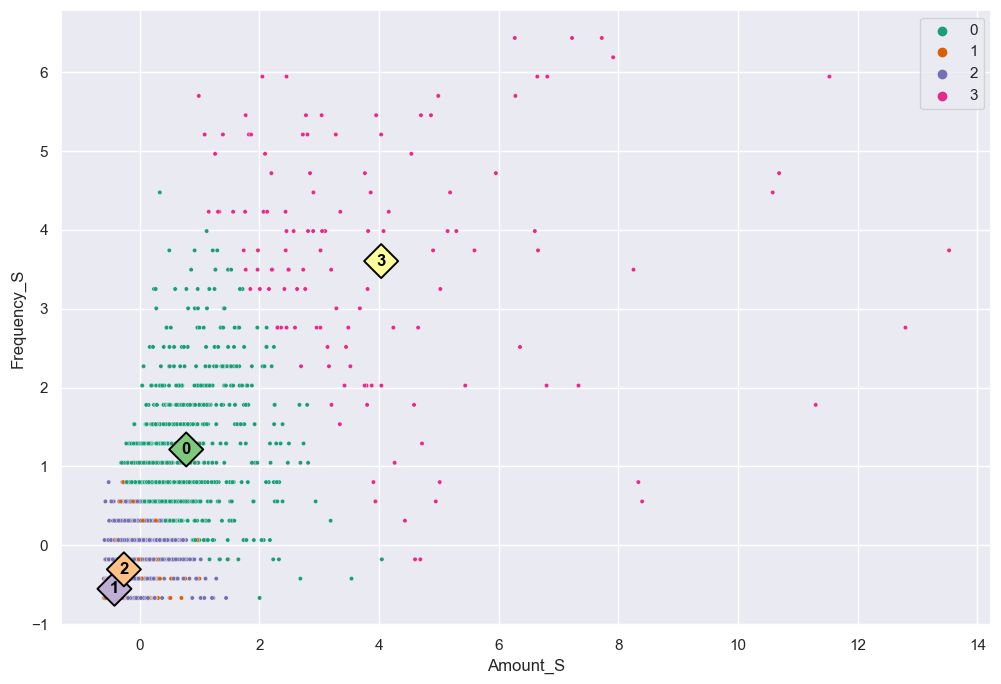

In [17]:
#Plot the Clusters
ax = sns.scatterplot(data = dfss,
                     x = 'Amount_S',
                     y = 'Frequency_S', 
                     hue = kmeans.labels_, 
                     palette= 'Dark2',
                     s = 10,
                     legend = True)

#Plot the Centroids
ax = sns.scatterplot(data = cluster_centers, 
                     x = 'Amount',
                     y = 'Frequency', 
                     hue = cluster_centers.index, 
                     palette = 'Accent', 
                     s = 300,
                     marker = 'D',
                     ec = 'black', 
                     legend = False)

# Add Centroid Labels
for i in range(len(cluster_centers)):
               plt.text(x = cluster_centers.Amount[i], 
                        y = cluster_centers.Frequency[i],
                        s = i, 
                        horizontalalignment='center',
                        verticalalignment='center',
                        size = 12,
                        weight = 'bold',
                        color = 'black')

### Visualise the clusters and cluster centroids with scatter plots.

##### In this scatter plot Amount and Recency are used

Parameters for the first scatter plot - customer scale data:
x = `Amount`
y = `Recency` 
hue = `cluster labels` 
size of plot points s = 10

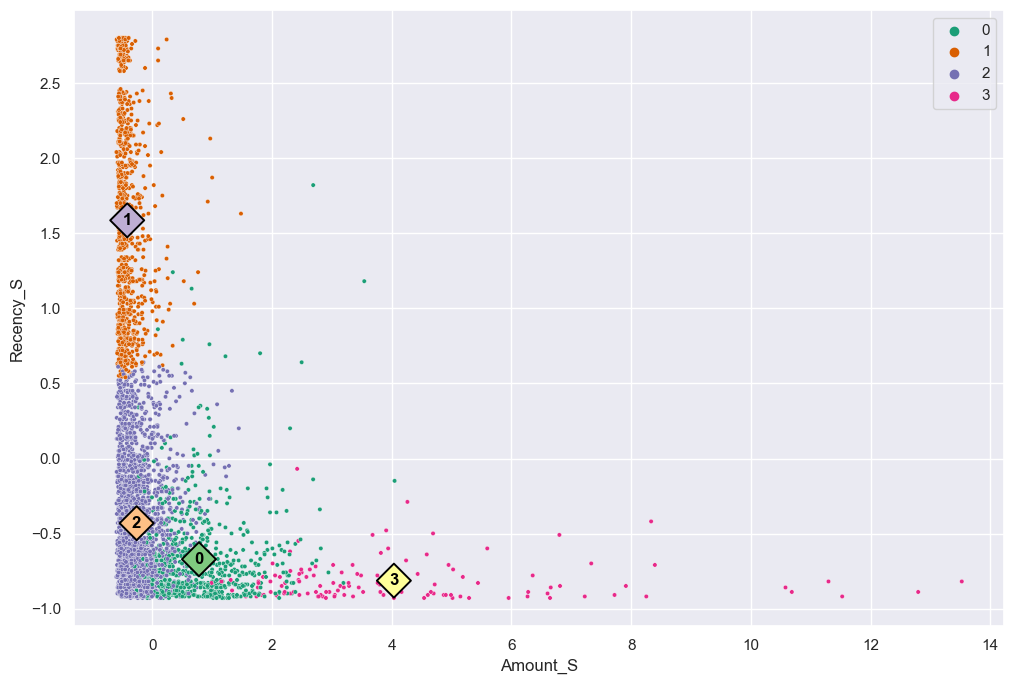

In [18]:
#Plot the Clusters
ax = sns.scatterplot(data = dfss,
                     x = 'Amount_S',
                     y = 'Recency_S', 
                     hue = kmeans.labels_, 
                     palette= 'Dark2',
                     s = 10,
                     legend = True)

#Plot the Centroids
ax = sns.scatterplot(data = cluster_centers, 
                     x = 'Amount',
                     y = 'Recency', 
                     hue = cluster_centers.index, 
                     palette = 'Accent', 
                     s = 300,
                     marker = 'D',
                     ec = 'black', 
                     legend = False)

# Add Centroid Labels
for i in range(len(cluster_centers)):
               plt.text(x = cluster_centers.Amount[i], 
                        y = cluster_centers.Recency[i],
                        s = i, 
                        horizontalalignment='center',
                        verticalalignment='center',
                        size = 12,
                        weight = 'bold',
                        color = 'black')

Count the number of items in each cluster

In [19]:
pie4 = pd.Series(kmeans.labels_).value_counts().sort_index()
pie4

0     688
1    1008
2    2409
3     128
dtype: int64

<div class="alert alert-block alert-info">
<b> </b> </div>

 <h1 style="text-align: center">Evaluation of the four centroid clustering (with k = 4)</h1>

<div class="alert alert-block alert-info">
<b> </b> </div>

  <h1 style="text-align: center">Four Segments Total Customers = 4233</h1>

<table style="float: center">
<thead>
<tr><th>Cluster Number</th><th>Assigned</th><th>Percentage</th></tr>
</thead>
<tbody>
<tr><td>0</td><td>688</td><td>16.3%</td></tr>
<tr><td>1</td><td>1008</td><td>23.8%</td></tr>
<tr><td>2</td><td>2409</td><td>56.9%</td></tr>
<tr><td>3</td><td>128</td><td>3.0%</td></tr>
</tbody>
</table>  

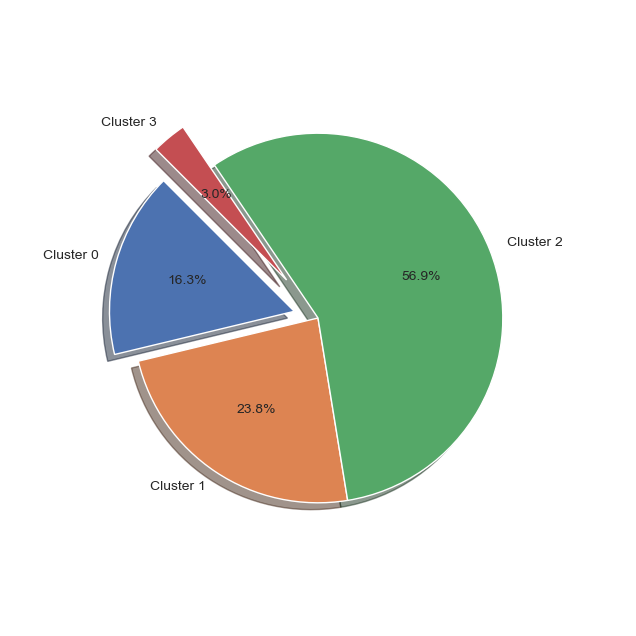

In [20]:
explode = (0.1, 0, 0, 0.2)  # "explode" the 1st slice ('Cluster 0') and the last slice ('Cluster 3')
labels = 'Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'
fig, ax = plt.subplots()
ax.pie(pie4, explode=explode, labels=labels, autopct='%1.1f%%',
       textprops={'size': 'smaller'}, radius=0.75,
       shadow=True, startangle=135)
plt.show()

## Cluster Analysis (four cluster model)


##### Cluster 0 
`Cluster 0` is the second smallest of the four clusters with 688 customers.   
Customers in `cluster 0` spend more than average, but not as much as customers in `cluster 3`. The frequent the online retailer more than average and tend to be less recent customers at the online retailer.
  
##### Cluster 1 
`Cluster 1` with 1,008 customers is the bigger than `Cluster 0` but less than half the size of `Cluster 2`. Customers in `Cluster 1`spend the least are the most recent but are the least frequent customers at the online retailer.
  
##### Cluster 2
`Cluster 2` is the largest of the four clusters with 2,409 customers which is more than twice the size of `cluster 1`. Customers in `Cluster 2` are the least favourable customers since they spend less are less recent and shop less frequently at the online retailer than any of the other clusters.

##### Cluster 3
`Cluster 3` is the smallest of the four clusters with 128 customers which is a fraction of the size of `Cluster 2`.   Customers in `Cluster 3` spend the most, are the least recent customers but most frequent shoppers at the online retailer .

## Cluster Analysis: Comparing the four clusters with the three and five cluster models)

The statistical tests for the ideal number of clusters to use in the model were inconsistent and that a three cluster seemed to statistically be the best option it was decided to run model with three and five clusters respectively. Please see Annex 1 and Annex 2 for the details of these two models. 
   
    
#### Three cluster model
Statistically the three cluster model would be the most appropriate number of clusters. However when running the three cluster model the results were not as evenly distributed as anticipated.
<table style="float: left">
<thead>    
<tr><th> Cluster</th><th> Assigned </th><th> Percentage </th></tr>
</thead>
<tbody>
<tr><td>0</td><td>2842</td><td>67.1%</td></tr>
<tr><td>1</td><td>1059</td><td>25.1%</td></tr>
<tr><td>2</td><td>332</td><td>7.8%</td></tr>
</tbody>
</table>   

    

`Cluster 3` is disappointedly smaller and the other two clusters with `Cluster 0` be disproportionately larger than the rest. Considering the project objectives this would not provide the online retailer with sufficient customer segments or provide a more nuanced explanation of customer buying habits. 

#### Five cluster model
Statistically the five cluster model would not be an appropriate number of clusters. Running the five cluster model confirmed that the distribution would not be even.
    
    
<table style="float: left">
<thead>
<tr><th> Cluster Number </th><th> Assigned </th><th> Percentage </th></tr>
</thead>
<tbody>
<tr><td>0</td><td>2175</td><td>51%</td></tr>
<tr><td>1</td><td>231</td><td>5.4%</td></tr>
<tr><td>2</td><td>1009</td><td>23.5%</td></tr>
<tr><td>3</td><td>837</td><td>19.5%</td></tr>
<tr><td>4</td><td>34</td><td>0.8%</td></tr>
</tbody>
</table>  

`Cluster 4` is disappointedly smaller and the other clusters and with just `34 customers` this cluster is pointless and add no value to the model. `Cluster 1` is the largest cluster hosting half the customers  while clusters two and three are reasonably similar in size. Considering that one of the five clusters is tiny to the point of being useless the best compromise for this project is the `four cluster model`.


## Conclusion
The evaluation of the four centroid model (with k = 4) reveals distinct customer clusters. Cluster 0, the smallest with 131 customers, comprises high-spending, frequent, and recent shoppers. Cluster 1, the largest with 2,441 customers, includes low-spending, less frequent, but recent shoppers. Clusters 2 and 3, with 1,022 and 692 customers respectively, show varying spending and shopping frequencies, with Cluster 3 being more recent and frequent than Cluster 2 but less so than Cluster 0.

## Assigning cluster numbers to the original data

* Create a new column in the dataset to hold the cluster assignment.
* Assign the cluster numbers to the customers in the original data frame.
* Drop the standardised columns 'Amount_S, 'Frequency_S', and 'Recency_S' as they are no longer required in the data frame.
* The next step is the analyze the the characteristics of each segment.

In [21]:
dfs['Sales_Cluster'] = kmeans.labels_.tolist()
dfs = dfs.drop(['Amount_S', 'Frequency_S', 'Recency_S'], axis=1)
dfs.sample(5)

,CustomerID,Amount,Frequency,Recency,Sales_Cluster
2474,15754,458.57,3,52,2
1387,14257,3099.72,5,65,1
1595,14542,103.25,1,186,0
940,13630,2031.78,7,6,2
1235,14045,1659.75,4,110,1


### Return descriptive statistics for each feature

In [22]:
dfs.agg({
    'Amount': 'median',
    'Frequency': 'mean',
    'Recency': 'median'}).round(2)

Amount       661.52
Frequency      3.72
Recency       52.00
dtype: float64

### Return descriptive statistics for each cluster
Return descriptive statistics for each features, but grouped by cluster.

In [23]:
dfg = dfs.groupby('Sales_Cluster').agg({
    'Amount': 'median',
    'Frequency': 'mean',
    'Recency': 'median'}).round(2)
dfg

,Amount,Frequency,Recency
Sales_Cluster,,,
0,708.68,3.78,51.0
1,622.26,3.61,54.0
2,668.36,3.73,52.0
3,607.14,4.09,41.0


# Conclusion and Recommendations

## Conclusion
By comparing the median statistics of each feature with the median statistics of each cluster, a more nuanced understanding of the customer profiles within each cluster is achieved, as discussed below.

* **Cluster 0:** comprises the highest spending customers, whose expenditure is ten percent higher than that of the median customer. These customers are not the most frequent or most recent, thus representing high-spending, though less frequent, and less recent customers.(Profile: Star)
* **Cluster 1:** includes customers who spend slightly less than the median, shop somewhat frequently, but are not particularly recent customers.(Profile: Occasional)
* **Cluster 2:** consists of customers who spend slightly more than the median customer, visit the online retailer regularly, and exhibit steady shopping patterns. This segment is considered the most loyal customers.(Profile: Loyal_Plus)
* **Cluster 3:** encompasses customers who spend the least but are the most frequent and most recent. This cluster represents regular, reliable, and loyal customers, but they not the biggest spenders.(Profile: Loyal_Low)


## Recommendations
* **Cluster 0:** This cluster comprises customers who exhibit the highest spending, with frequent and recent visits, indicating strong loyalty. It is recommended to implement promotional strategies to reward these customers, ensuring their continued satisfaction and retention.
* **Cluster 1:** This cluster includes average customers who neither spend significantly nor shop frequently or recently. To enhance engagement, targeted promotions or advertising campaigns aimed at increasing their visit frequency and expenditure should be considered. Sale promotions or loyalty programs may be particularly effective.
* **Cluster 2:** This cluster consists of average loyal customers who spend above average and exhibit regular shopping patterns. Marketing strategies should focus on increasing the spending of these customers, encouraging them to spend more through targeted sales or loyalty strategies.
* **Cluster 3:** This cluster represents regular, reliable, and loyal customers, although they spend the least. Promotional strategies to reward these customers could further solidify their loyalty. Additionally, initiatives to encourage increased spending within this segment should be considered.
  
Overall, the four clusters demonstrate that the online retailer has loyal and regular customers with diverse spending habits. Marketing strategies should focus on encouraging increased expenditure from customers in Clusters 1 and 3 Consider implementing promotions or loyalty schemes for all clusters.



## Export the market segmentation sales transactions to Excel

In [24]:
#dfs.to_excel('Sales_Cluster.xlsx', sheet_name='Sales_Cluster', index=True)

<div class="alert alert-block alert-info">
<b> </b> </div>

# END Part II market segmentation of sales transactions

<div class="alert alert-block alert-info">
<b> </b> </div>

#### See Part I for the market segmentation ETL and EPA processes
https://github.com/andrewcollodel/Data-Science-Portfolio/blob/main/1_PART_I_Online_Retail_Market_Segmentation_ETL_EPA.ipynb
#### See Part III for market segmentation returns transactions(Credit Invoices)
https://github.com/andrewcollodel/Data-Science-Portfolio/blob/main/3_PART_III_Online_Retail_Credit_Segmentation_Returns.ipynb
#### See Part IV for the Analysis of customer purchasing habits and proposed action plan
https://github.com/andrewcollodel/Data-Science-Portfolio/blob/main/4_PART_IV_Online_Retail_Market_Segmentation_Summary.ipynb

<div class="alert alert-block alert-info">
<b> </b> </div>

<h1 style="text-align: center">Annex 1: Sales Transactions with 3 clusters</h1>

<div class="alert alert-block alert-info">
<b> </b> </div>

## Evaluation of the three centroid clustering (with k = 3)
The goal of this project is to conduct a market segmentation of an online retailer’s customers and develop customer profiles based on the purchasing and returns habits. 

Three clusters returned an unbalanced spread of customers per cluster with three quaters of the customers in cluster 0. The four clusters still provides the best customer distribution to meet the project objectives.




  <h1 style="text-align: center"> Three Segments Total Customers = 4233 </h1>

<table style="float: center">
<thead>    
<tr><th> Cluster Number </th><th> Assigned </th><th> Percentage </th></tr>
</thead>
<tbody>
<tr><td>0</td><td>2842</td><td>67.1%</td></tr>
<tr><td>1</td><td>1059</td><td>25.1%</td></tr>
<tr><td>2</td><td>332</td><td>7.8%</td></tr>
</tbody>
</table>

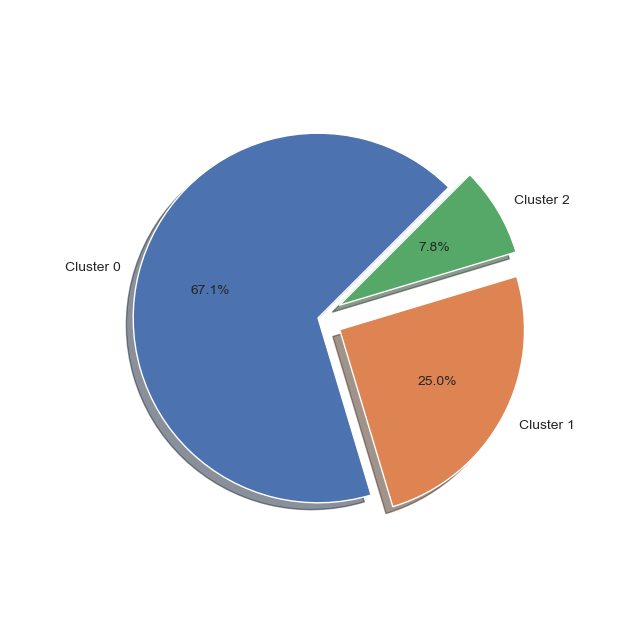

In [25]:
pie3 = [2842,1059,332]
explode = (0, 0.1, 0.1)  # "explode" the 2nd (Cluster 1) and 3rd slice ('Cluster 2')
labels3 = 'Cluster 0', 'Cluster 1', 'Cluster 2'
fig, ax = plt.subplots()
ax.pie(pie3, explode=explode, labels=labels3, autopct='%1.1f%%',
       textprops={'size': 'smaller'}, radius=0.75,
       shadow=True, startangle=45)
plt.show()

In [26]:
kmeans3 = KMeans(n_clusters = 3, n_init = 25, random_state = 1234)

In [27]:
kmeans3.fit(dfss)

KMeans(n_clusters=3, n_init=25, random_state=1234)

In [28]:
kmeans3.labels_

array([0, 0, 1, ..., 0, 2, 0])

In [29]:
kmeans3.inertia_

4418.039889065931

In [30]:
pd.Series(kmeans3.labels_).value_counts().sort_index()

0    2842
1    1059
2     332
dtype: int64

In [31]:
kmeans3.cluster_centers_

array([[-0.12722016, -0.10445112, -0.48610418],
       [-0.41899703, -0.54656885,  1.53536314],
       [ 2.39012142,  2.65396504, -0.7512079 ]])

In [32]:
cluster_centers3 = pd.DataFrame(kmeans3.cluster_centers_, columns = ['Amount','Frequency','Recency'])
cluster_centers3

,Amount,Frequency,Recency
0,-0.127220,-0.104451,-0.486104
1,-0.418997,-0.546569,1.535363
2,2.390121,2.653965,-0.751208


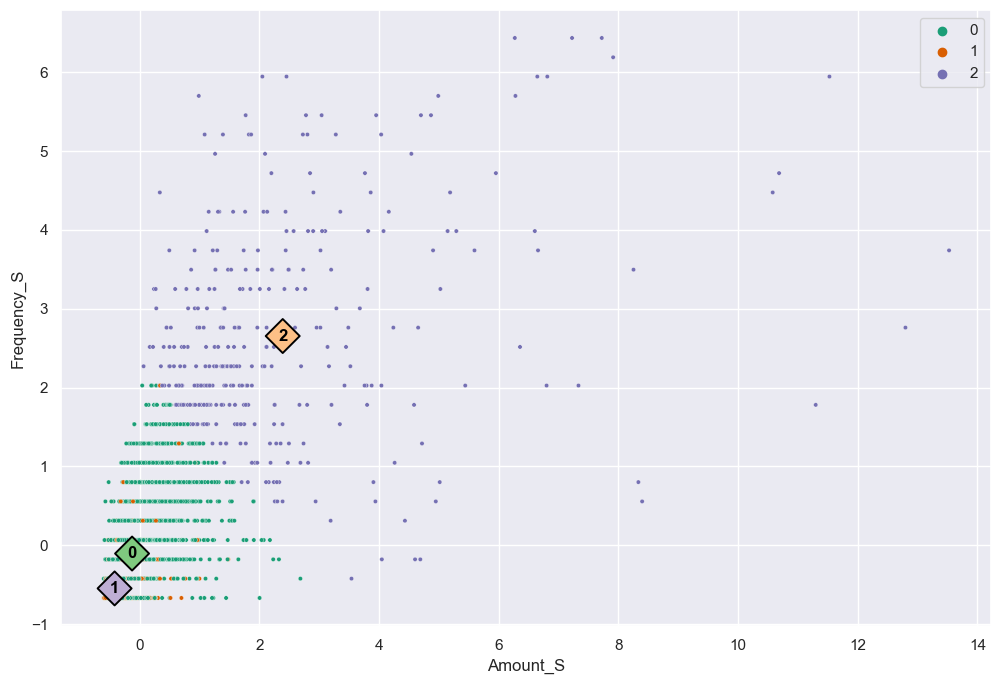

In [33]:
#Plot the Clusters
ax = sns.scatterplot(data = dfss,
                     x = 'Amount_S',
                     y = 'Frequency_S', 
                     hue = kmeans3.labels_, 
                     palette= 'Dark2',
                     s = 10,
                     legend = True)

#Plot the Centroids
ax = sns.scatterplot(data = cluster_centers3, 
                     x = 'Amount',
                     y = 'Frequency', 
                     hue = cluster_centers3.index, 
                     palette = 'Accent', 
                     s = 300,
                     marker = 'D',
                     ec = 'black', 
                     legend = False)

# Add Centroid Labels
for i in range(len(cluster_centers3)):
               plt.text(x = cluster_centers3.Amount[i], 
                        y = cluster_centers3.Frequency[i],
                        s = i, 
                        horizontalalignment='center',
                        verticalalignment='center',
                        size = 12,
                        weight = 'bold',
                        color = 'black')

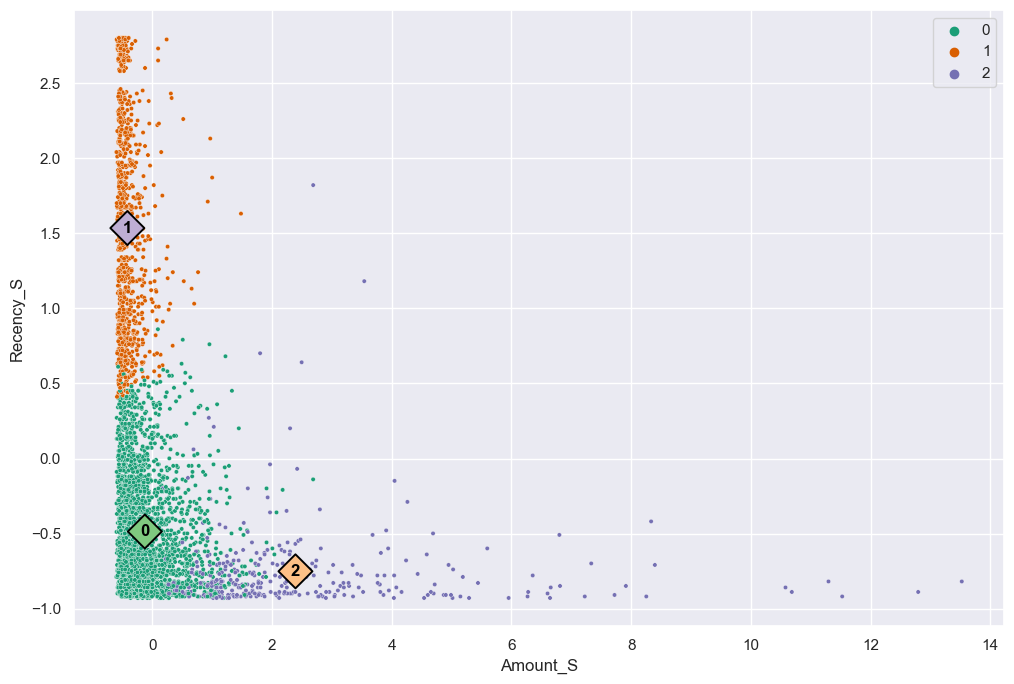

In [34]:
#Plot the Clusters
ax = sns.scatterplot(data = dfss,
                     x = 'Amount_S',
                     y = 'Recency_S', 
                     hue = kmeans3.labels_, 
                     palette= 'Dark2',
                     s = 10,
                     legend = True)

#Plot the Centroids
ax = sns.scatterplot(data = cluster_centers3, 
                     x = 'Amount',
                     y = 'Recency', 
                     hue = cluster_centers3.index, 
                     palette = 'Accent', 
                     s = 300,
                     marker = 'D',
                     ec = 'black', 
                     legend = False)

# Add Centroid Labels
for i in range(len(cluster_centers3)):
               plt.text(x = cluster_centers3.Amount[i], 
                        y = cluster_centers3.Recency[i],
                        s = i, 
                        horizontalalignment='center',
                        verticalalignment='center',
                        size = 12,
                        weight = 'bold',
                        color = 'black')

<div class="alert alert-block alert-info">
<b> </b> </div>

<h1 style="text-align: center">Annex 2: Sales Transactions with 5 clusters</h1>

<div class="alert alert-block alert-info">
<b> </b> </div>

## Evaluation of the five centroid clustering (with k = 5)

Evaluation of the five centroid clustering (with k = 5)
The goal of this project is to conduct a market segmentation of an online retailer’s customers and develop customer profiles based on the purchasing and returns habits.

Five clusters returned an unbalanced spread of customers per cluster with half of the customers in cluster 0 and another quarter in cluster 2. Cluster 4 was pointless as it only contained 0.8% (34) customers The four clusters still provides the best distribution of customers to meet the project objectives

  <h1 style="text-align: center"> Five Segments  Total Customers = 4233 </h1>


<table style="float: center">
<thead>
<tr><th> Cluster Number </th><th> Assigned </th><th> Percentage </th></tr>
</thead>
<tbody>
<tr><td>0</td><td>2175</td><td>51%</td></tr>
<tr><td>1</td><td>231</td><td>5.4%</td></tr>
<tr><td>2</td><td>1009</td><td>23.5%</td></tr>
<tr><td>3</td><td>837</td><td>19.5%</td></tr>
<tr><td>4</td><td>34</td><td>0.8%</td></tr>
</tbody>
</table>  

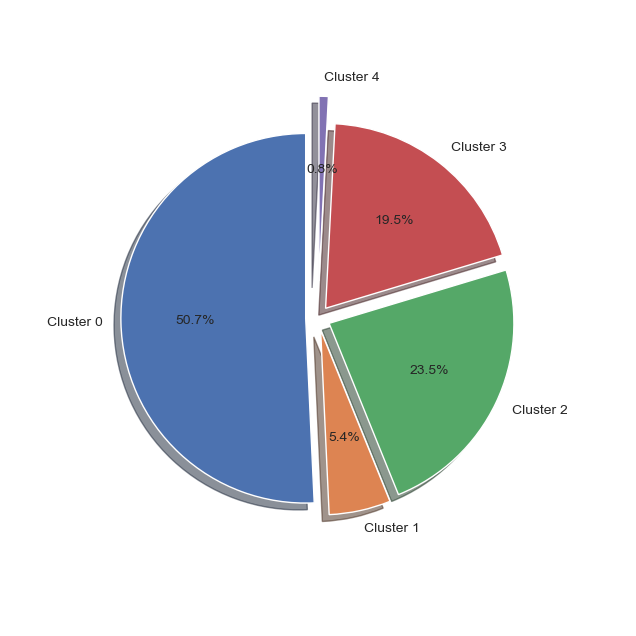

In [35]:
pie5 = [2175,231,1009,837,35]
explode = (0.05, 0.05, 0.05, 0.05,0.15)  # only "explode" the 3rd slice (i.e. 'Cluster 2')
labels5 = 'Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'
fig, ax = plt.subplots()
ax.pie(pie5, explode=explode, labels=labels5, autopct='%1.1f%%',
       textprops={'size': 'smaller'}, radius=0.75,
       shadow=True, startangle=90)
plt.show()

In [36]:
kmeans5 = KMeans(n_clusters = 5, n_init = 25, random_state = 1234)

In [37]:
kmeans5.fit(dfss)

KMeans(n_clusters=5, n_init=25, random_state=1234)

In [38]:
kmeans5.labels_

array([1, 1, 2, ..., 1, 0, 1])

In [39]:
kmeans5.inertia_

2532.4158357671386

In [40]:
pd.Series(kmeans5.labels_).value_counts().sort_index()

0     229
1    2147
2     995
3     829
4      33
dtype: int64

In [41]:
kmeans5.cluster_centers_

array([[ 2.0708961 ,  2.77877379, -0.75121813],
       [-0.31794187, -0.38181512, -0.40417313],
       [-0.42125865, -0.55132677,  1.5992425 ],
       [ 0.45771378,  0.72879334, -0.6385884 ],
       [ 7.26149696,  4.15567382, -0.83414908]])

In [42]:
cluster_centers5 = pd.DataFrame(kmeans5.cluster_centers_, columns = ['Amount','Frequency','Recency'])
cluster_centers5

,Amount,Frequency,Recency
0,2.070896,2.778774,-0.751218
1,-0.317942,-0.381815,-0.404173
2,-0.421259,-0.551327,1.599243
3,0.457714,0.728793,-0.638588
4,7.261497,4.155674,-0.834149


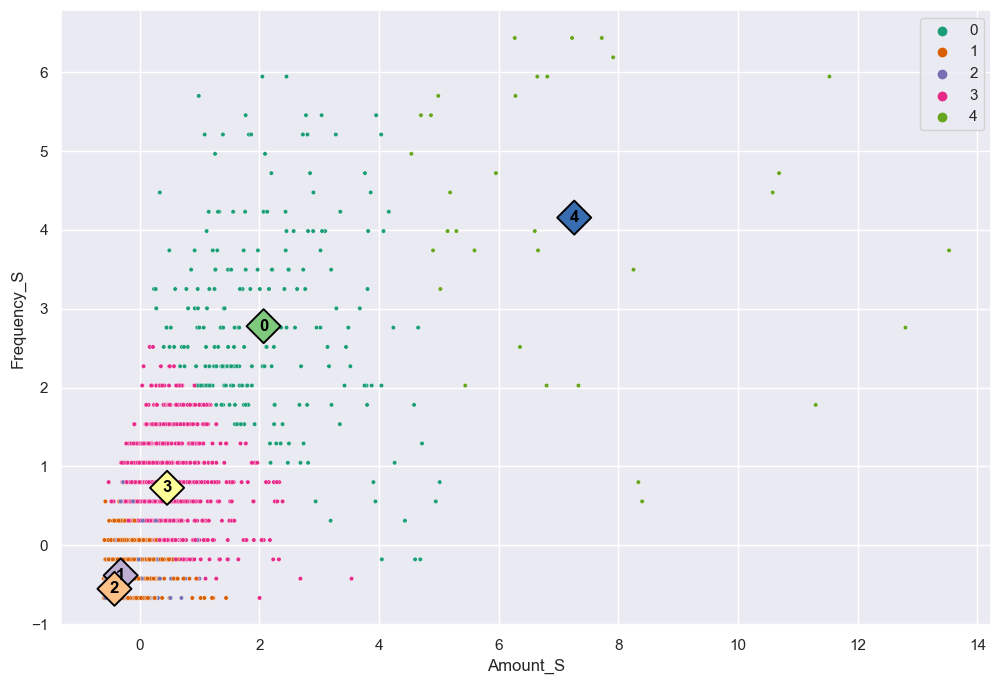

In [43]:
#Plot the Clusters
ax = sns.scatterplot(data = dfss,
                     x = 'Amount_S',
                     y = 'Frequency_S', 
                     hue = kmeans5.labels_, 
                     palette= 'Dark2',
                     s = 10,
                     legend = True)

#Plot the Centroids
ax = sns.scatterplot(data = cluster_centers5, 
                     x = 'Amount',
                     y = 'Frequency', 
                     hue = cluster_centers5.index, 
                     palette = 'Accent', 
                     s = 300,
                     marker = 'D',
                     ec = 'black', 
                     legend = False)

# Add Centroid Labels
for i in range(len(cluster_centers5)):
               plt.text(x = cluster_centers5.Amount[i], 
                        y = cluster_centers5.Frequency[i],
                        s = i, 
                        horizontalalignment='center',
                        verticalalignment='center',
                        size = 12,
                        weight = 'bold',
                        color = 'black')

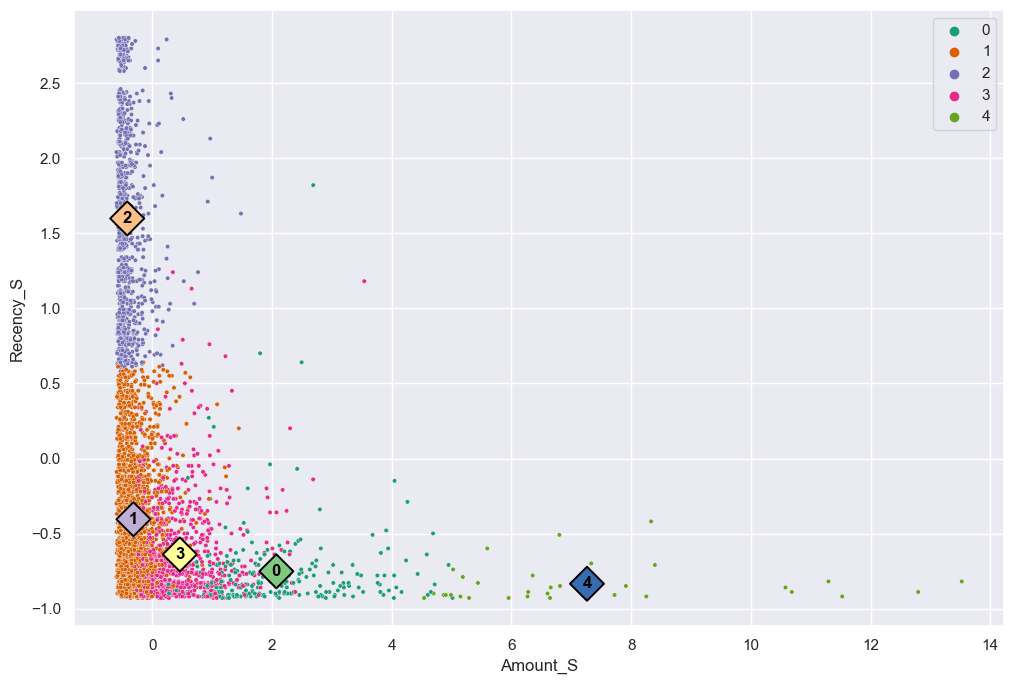

In [44]:
#Plot the Clusters
ax = sns.scatterplot(data = dfss,
                     x = 'Amount_S',
                     y = 'Recency_S', 
                     hue = kmeans5.labels_, 
                     palette= 'Dark2',
                     s = 10,
                     legend = True)

#Plot the Centroids
ax = sns.scatterplot(data = cluster_centers5, 
                     x = 'Amount',
                     y = 'Recency', 
                     hue = cluster_centers5.index, 
                     palette = 'Accent', 
                     s = 300,
                     marker = 'D',
                     ec = 'black', 
                     legend = False)

# Add Centroid Labels
for i in range(len(cluster_centers5)):
               plt.text(x = cluster_centers5.Amount[i], 
                        y = cluster_centers5.Recency[i],
                        s = i, 
                        horizontalalignment='center',
                        verticalalignment='center',
                        size = 12,
                        weight = 'bold',
                        color = 'black')

<div class="alert alert-block alert-info">
<b> </b> </div>

# END

<div class="alert alert-block alert-danger">
<b> </b> </div>